In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from typing import List, Union
from collections import OrderedDict
import itertools
from qiskit.quantum_info import Statevector
import multiprocessing as mp
from math import pi
from scipy.special import logsumexp

num_qubits = 2

In [1]:
def final_circuit(circuit, data, params):
    d = len(params)
    layers = d//num_qubits
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(num_qubits):
        circuit.h(i)
    for j in range(layers-1):
        for i in range(num_qubits):
            circuit.ry(data[i], i)
            circuit.rz(data[i+2],i)
        circuit.cx(0,1)
        circuit.ry(angle_y, 0)
        circuit.rz(angle_z, 1)
        circuit.cx(0,1)
        for i in range(num_qubits):
            circuit.ry(params[i+num_qubits*j],i)
        circuit.cx(0,1)
        
    for i in range(num_qubits):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    for i in range(num_qubits):
        circuit.ry(params[i+num_qubits*(layers-1)],i)

In [4]:
def _parity():
    y1 = []
    y2 = []
    basis_states = [list(i) for i in itertools.product([0, 1], repeat=num_qubits)]
    for idx, k in enumerate(basis_states):
        parity = sum(int(k[i]) for i in range(len(k)))
        if parity % 2 == 0:
            y1.append(idx)
        else:
            y2.append(idx)
    return {'y1': y1, 'y2': y2}

In [5]:
def get_probabilities(params, x):
    
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            #circuit_ = circuit.assign_parameters(self._get_params_dict(theta, data))
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
    params = np.array(params)
    x = np.array(x)      
    
     # specify number of parallel processes
    num_processes = 2

        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()
    probabilities = []
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities += [results[start:end]]

    return probabilities

In [6]:
def get_gradient(params, x):
    grads = []
    qc_plus = []
    qc_minus = []
    zeros = np.zeros(np.shape(params))
    for i in range(d):
        print(i)
        zeros[:, i] = np.pi / 2.
        qc_plus += [get_probabilities(params+zeros, x)]
        qc_minus += [get_probabilities(params-zeros, x)]
        zeros[:, i] = 0
        grads.append((np.array(qc_plus[i]) - np.array(qc_minus[i])) * 0.5)
    grads = np.array(grads)
    print(grads)
        # reshape the dp_thetas
    full = np.zeros((len(x), d, 2**num_qubits))
    for j in range(len(x)):
        row = np.zeros((d, 2**num_qubits))
        for i in range(d):
            tensor = grads[i]
            row[i] += tensor[j]
        full[j] += row
    return full

In [7]:
def forward(params, x):
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            #circuit_ = circuit.assign_parameters(self._get_params_dict(theta, data))
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
        # map input to arrays
    params = np.array(params)
    x = np.array(x)
        # specify number of parallel processes
    num_processes = 2
        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()

    aggregated_results = np.zeros((len(x), outputsize))
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities = results[start:end]
        temp_ = []
        for y in post_processing.keys():
            index = post_processing[y]  # index for each label
            temp_.append([sum(probabilities[u] for u in index)])
        temp_ = np.reshape(temp_, (1, outputsize))
        aggregated_results[i] = temp_
    return aggregated_results

In [8]:
def get_fisher(gradients, model_output):
    gradvectors = []
    for k in range(len(gradients)):
        jacobian = []
        m_output = model_output[k]  # p_theta size: (1, outputsize)
        jacobians_ = gradients[k, :, :]  # dp_theta size: (d, 2**num_qubits)
        for idx, y in enumerate(post_processing.keys()):
            index = post_processing[y]  # index for each label
            denominator = m_output[idx]  # get correct model output sum(p_theta) for indices
            for j in range(d):
                row = jacobians_[j, :]
                    # for each row of a particular dp_theta, do sum(dp_theta)/sum(p_theta) for indices
                    # multiply by sqrt(sum(p_theta)) so that the outer product cross term is correct
                jacobian.append(np.sqrt(denominator)*(sum(row[u] for u in index) / denominator))
            # append gradient vectors for every output for all data points
        gradvectors.append(np.reshape(jacobian, (outputsize, d)))
        print(np.reshape(jacobian, (outputsize, d)))
        # full gradient vector
    gradients = np.reshape(gradvectors, (len(gradients), outputsize, d))

    fishers = np.zeros((len(gradients), d, d))
    for i in range(len(gradients)):
        grads = gradients[i]  # size = (outputsize, d)
        temp_sum = np.zeros((outputsize, d, d))
        for j in range(outputsize):
            temp_sum[j] += np.array(np.outer(grads[j], np.transpose(grads[j])))
        fishers[i] += np.sum(temp_sum, axis=0)  # sum the two matrices to get fisher estimate
    return fishers

In [9]:
d = 10
num_qubits = 2
inputsize = 4
outputsize = 2
post_processing = OrderedDict(_parity())
sv = Statevector.from_label('0' * num_qubits)

num_inputs = 100
num_thetas = 100
thetamin = -1
thetamax = 1

rep_range = np.tile(np.array([num_inputs]), num_thetas)
params_ = np.random.uniform(thetamin, thetamax, size=(num_thetas, d))
params = np.repeat(params_, repeats=rep_range, axis=0)
x_ = np.random.normal(0, 1, size=(num_inputs, inputsize))
x = np.tile(x_, (num_thetas, 1))

In [10]:
def get_fhat():
    grads = get_gradient(params, x)
    output = forward(params, x)
    fishers = get_fisher(grads, output)
    fisher_trace = np.trace(np.average(fishers, axis=0))
    fisher = np.average(np.reshape(fishers, (num_thetas, num_inputs, d, d)), axis=1)
    f_hat = d * fisher / fisher_trace
    return f_hat, fisher_trace

In [11]:
def eff_dim(f_hat, n):
        """
        Compute the effective dimension.
        :param f_hat: ndarray
        :param n: list, used to represent number of data samples available as per the effective dimension calc
        :return: list, effective dimension for each n
        """
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return np.array(effective_dim)/d

In [12]:
n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

###################################################################################

#ed = EffectiveDimension(qnet, num_thetas=num_thetas, num_inputs=num_inputs)
f, trace = get_fhat()

#np.save("4qubits_9layer_f_hats_pauli.npy", f)
#np.save("4qubits_9layer_effective_dimension_pauli.npy", effdim)

0
1
2
3
4
5
6
7
8
9
[[[-0.03950499  0.06010576 -0.01516104 -0.00543974]
  [ 0.13554564  0.13777727 -0.3951007   0.12177779]
  [ 0.08086301  0.03134338 -0.37973896  0.26753257]
  ...
  [ 0.24229469 -0.04751265  0.04992474 -0.24470678]
  [-0.0377072   0.06054537  0.09844501 -0.12128318]
  [-0.17101937  0.07745056  0.08651308  0.00705572]]

 [[-0.03646881  0.00937374  0.01206792  0.01502716]
  [ 0.11574627  0.15614796 -0.39874033  0.1268461 ]
  [ 0.01159884  0.07800999  0.19300585 -0.28261468]
  ...
  [-0.00098947  0.05531785  0.09708687 -0.15141524]
  [ 0.12286904  0.04045728 -0.10331123 -0.06001509]
  [-0.26299705  0.04189972  0.32057066 -0.09947333]]

 [[-0.01269718 -0.33892696  0.18064396  0.17098018]
  [ 0.12006644 -0.07067879 -0.05655203  0.00716437]
  [ 0.1184304  -0.08904195  0.19873457 -0.22812302]
  ...
  [-0.11539259 -0.01268465 -0.05755983  0.18563706]
  [-0.05460323 -0.11224747 -0.02854763  0.19539833]
  [-0.09891903 -0.12544546  0.20207074  0.02229375]]

 ...

 [[-0.03266033

  -0.01537023 -0.07045205 -0.02363513  0.18186271]]
[[-0.66066658 -0.03571709  0.11739168 -0.07525576 -0.02508444 -0.09169085
   0.18296555 -0.31019418 -0.52083329  0.06871862]
 [ 0.62271985  0.0336656  -0.11064905  0.07093329  0.02364366  0.0864244
  -0.17245656  0.29237754  0.49091817 -0.06477162]]
[[-0.22412385 -0.57000609 -0.04648032  0.57986064  0.06317223 -0.10571468
  -0.25291903 -0.3622098   0.16615188  0.75896594]
 [ 0.10876143  0.27660902  0.02255568 -0.28139118 -0.03065583  0.05130056
   0.12273498  0.17577093 -0.08062916 -0.36830629]]
[[-0.08252672  0.26544433 -0.04663216  0.54497688 -0.38273167  0.15681745
  -0.09560767 -0.01849001 -0.48881452 -0.46604239]
 [ 0.0432023  -0.1389587   0.02441169 -0.28529252  0.20035801 -0.08209311
   0.05005011  0.00967942  0.25589182  0.24397073]]
[[ 0.18484938  0.30118942  0.0134717  -0.09668758  0.07836907  0.0454534
   0.21025674 -0.10167388  0.26787482 -0.25502929]
 [-0.1315142  -0.21428627 -0.00958467  0.06879    -0.05575699 -0.0323385

  -0.06079038 -0.00168775  0.14016647  0.22122841]]
[[-0.09510732 -0.52648815 -0.32430328 -0.14995645 -0.30840698  0.57901427
  -0.13032906 -0.68653469 -0.32294943 -0.66819663]
 [ 0.03556915  0.19690113  0.12128608  0.05608216  0.11534102 -0.21654536
   0.04874172  0.25675688  0.12077975  0.24989864]]
[[ 0.2591203   0.46938904 -0.45581273 -0.00826632  0.30967061 -0.4413244
  -0.01895921  0.11442664  0.11003993  0.57431298]
 [-0.16052139 -0.29077993  0.2823696   0.00512087 -0.1918366   0.27339428
   0.01174496 -0.0708857  -0.0681682  -0.35577883]]
[[-0.35359394 -0.20407328 -0.56909269 -0.27321287 -0.55814202 -0.59635561
  -0.34173542  0.36921242 -0.66358579 -0.34302814]
 [ 0.15178849  0.08760324  0.24429638  0.11728303  0.23959555  0.25599962
   0.14669794 -0.15849309  0.28485975  0.14725287]]
[[ 0.18791102 -0.0088798   0.06700648  0.18595862  0.47098876 -0.51796974
   0.22726722 -0.01119687  0.22181268 -0.17833071]
 [-0.14704942  0.00694887 -0.0524358  -0.14552157 -0.36857139  0.405336

  -0.17980124  0.08242835  0.0145175  -0.35459781]]
[[-0.23002125  0.3095173  -0.09337074  0.16352921 -0.23234354 -0.28452822
   0.33041987 -0.1712396  -0.17096923  0.15612213]
 [ 0.31292613 -0.42107436  0.12702367 -0.22246885  0.31608542  0.38707865
  -0.4495107   0.23295824  0.23259042 -0.21239209]]
[[ 0.2372049   0.40624831 -0.25088148  0.38958834 -0.3916261   0.11060449
   0.42428759 -0.30269573 -0.29236513  0.34832345]
 [-0.16992973 -0.29102968  0.17972741 -0.27909474  0.28055456 -0.07923525
  -0.30395272  0.21684629  0.20944562 -0.24953325]]
[[-0.01896873 -0.07626318  0.16624534 -0.16611441  0.15197706 -0.29415542
  -0.2182158  -0.09313291 -0.34356353  0.2198526 ]
 [ 0.04336503  0.17434775 -0.3800589   0.37975956 -0.34743972  0.6724783
   0.49887026  0.21291419  0.78543179 -0.50261221]]
[[-0.00371831 -0.13368539  0.12933772 -0.18813616 -0.21630593 -0.32597706
   0.13419573 -0.39243851 -0.35646993 -0.09821484]
 [ 0.00349787  0.12575988 -0.12166997  0.17698255  0.20348228  0.306651

  -0.39616009  0.24567117 -0.1100118   0.34953782]]
[[ 0.56311013 -0.01841535 -0.53994509 -0.36465999  0.48988918  0.39002999
  -0.14060171 -0.3543584   0.23615202  0.57298976]
 [-0.35190449  0.01150831  0.33742796  0.22788702 -0.30614651 -0.24374149
   0.08786624  0.22144924 -0.14757851 -0.35807857]]
[[-0.03966523 -0.00260105  0.06559963 -0.13621727 -0.0706509  -0.07009953
  -0.06451217 -0.17743879  0.12223275 -0.04216032]
 [ 0.06514707  0.00427202 -0.10774231  0.22372632  0.11603863  0.11513305
   0.10595624  0.29142947 -0.20075783  0.06924507]]
[[-0.11845124 -0.25143186 -0.17780113  0.43586938  0.27841754  0.06093975
  -0.26933728  0.01756839 -0.10341275  0.40989887]
 [ 0.08522667  0.18090735  0.12792942 -0.31361171 -0.20032378 -0.04384666
   0.19379045 -0.01264061  0.07440635 -0.2949257 ]]
[[ 0.23586327  0.21647999 -0.06135456  0.25399134 -0.13783046 -0.04894274
  -0.50812302 -0.15775707  0.22677748 -0.55436226]
 [-0.29885326 -0.27429345  0.07774    -0.32182264  0.17463966  0.06201

[[ 0.21070907  0.39949438  0.11936369  0.02321531 -0.34808108  0.39525101
  -0.04018225 -0.46751628 -0.19994595  0.75061061]
 [-0.13653777 -0.25886911 -0.0773467  -0.01504333  0.22555371 -0.25611944
   0.02603777  0.30294675  0.12956335 -0.48638957]]
[[-3.65637245e-01 -1.29138567e-02 -5.87321975e-02 -1.19876109e-02
   5.90255209e-02 -4.87012770e-01  3.80997410e-01 -4.13181255e-04
   2.90070340e-01 -3.01558880e-01]
 [ 5.83771433e-01  2.06180873e-02  9.37710246e-02  1.91392559e-02
  -9.42393407e-02  7.77557939e-01 -6.08295263e-01  6.59679550e-04
  -4.63122344e-01  4.81464789e-01]]
[[ 0.15359607 -0.01529146  0.04850357 -0.05707949  0.25379736 -0.11812666
  -0.07591439  0.17850655  0.50914778 -0.19015111]
 [-0.14858046  0.01479213 -0.04691971  0.05521559 -0.24550973  0.11426929
   0.07343545 -0.1726775  -0.49252181  0.18394182]]
[[ 0.36647073  0.182928    0.42008427 -0.5591904   0.03378319  0.19774283
  -0.72937771  0.04445042 -0.59095677 -0.16836859]
 [-0.20460636 -0.10213158 -0.23453964 

   0.08439358 -0.03758986 -0.19465933  0.19280808]]
[[-0.09846996 -0.1383487   0.55218314  0.44317916 -0.31301331  0.00711577
  -0.03535555  0.38844811 -0.39289307  0.0616138 ]
 [ 0.09565879  0.13439906 -0.53641917 -0.43052709  0.30407726 -0.00691263
   0.03434621 -0.37735852  0.38167658 -0.05985482]]
[[-0.38101081 -0.13181652 -0.00149941  0.27132287 -0.02367466  0.63113497
   0.01049255 -0.36991475  0.12593525 -0.35158745]
 [ 0.26686426  0.09232577  0.0010502  -0.19003759  0.016582   -0.44205404
  -0.0073491   0.25909246 -0.08820647  0.24625581]]
[[ 0.51036218 -0.54239893 -0.43323483 -0.48991379  0.59086725 -0.39841986
  -0.50936799 -0.30505846  0.40379704 -0.59117396]
 [-0.37098609  0.39427384  0.31492164  0.356122   -0.42950583  0.28961438
   0.37026341  0.22174928 -0.29352309  0.42972878]]
[[-0.358328    0.00103173 -0.28737795  0.4086246   0.14631146 -0.12176175
  -0.20205052 -0.15787309  0.18552927  0.30637407]
 [ 0.20499573 -0.00059024  0.16440594 -0.23376989 -0.08370326  0.06965

  -0.06259848  0.05161885  0.14357159 -0.34402948]]
[[-0.26627552  0.2603249   0.41274924  0.424129    0.11594097  0.06722508
  -0.28160717 -0.04772068  0.16296468 -0.15515534]
 [ 0.25355458 -0.24788824 -0.39303072 -0.40386682 -0.11040205 -0.0640135
   0.26815377  0.04544089 -0.15517927  0.14774301]]
[[ 0.00807211  0.28351436  0.03725353 -0.37159194  0.12983651 -0.27763195
   0.43863108 -0.59277934  0.14158723 -0.02050683]
 [-0.00514801 -0.18081222 -0.02375856  0.23698399 -0.08280367  0.1770607
  -0.27973843  0.378047   -0.09029773  0.0130783 ]]
[[-0.2185804   0.17865802 -0.51179729  0.08854815  0.18975083 -0.33738557
  -0.21747669 -0.23153323 -0.23582087 -0.68734816]
 [ 0.12050572 -0.09849608  0.28215934 -0.04881755 -0.10461167  0.18600429
   0.11989724  0.12764676  0.13001058  0.37894243]]
[[-0.37375577  0.3949829  -0.1091718   0.42697172 -0.08053667 -0.18564787
  -0.13966562 -0.2935464  -0.64511375 -0.14882954]
 [ 0.26165009 -0.27651028  0.07642641 -0.29890425  0.0563802   0.1299639

   0.11759104  0.86713805  0.43616895  0.64811063]]
[[ 0.382984    0.28995917  0.0898886   0.02758979  0.1472353  -0.00645223
   0.06924033 -0.13297114 -0.00216429 -0.33158595]
 [-0.52339269 -0.39626332 -0.12284335 -0.03770469 -0.20121435  0.00881773
  -0.09462506  0.18172071  0.00295776  0.45315121]]
[[ 0.4195442  -0.15737087 -0.35367388  0.21393418 -0.21702281 -0.11996071
  -0.34216145 -0.14244755  0.47425939 -0.34160796]
 [-0.52828044  0.19815779  0.44533804 -0.26938102  0.27327014  0.15105178
   0.43084185  0.17936669 -0.59717655  0.43014491]]
[[ 0.59272376 -0.34176985  0.21036942  0.01850179 -0.02142317 -0.08239015
   0.06343748 -0.41000633  0.44774699 -0.09077427]
 [-0.62231297  0.35883126 -0.22087122 -0.01942542  0.02249263  0.08650312
  -0.06660433  0.43047415 -0.47009885  0.09530579]]
[[-0.31644139  0.14674421  0.23924077  0.07403548  0.17673937 -0.40764803
   0.06872869 -0.09766934  0.00155876 -0.25855425]
 [ 0.25657623 -0.11898278 -0.19398062 -0.06002927 -0.14330338  0.33052

[[-0.08295782  0.14076637 -0.08789734 -0.28124098 -0.10049508  0.24335337
   0.23521603 -0.06388017 -0.38419449 -0.26250588]
 [ 0.0460719  -0.07817677  0.04881514  0.1561915   0.05581149 -0.13515003
  -0.13063084  0.03547683  0.21336831  0.14578668]]
[[ 0.0886004  -0.09632519  0.06768207 -0.22095922  0.30509034 -0.17819411
   0.17420129  0.08576464  0.2773646  -0.3904513 ]
 [-0.19513184  0.21214476 -0.14906169  0.48663638 -0.67192516  0.39245131
  -0.38365761 -0.1888864  -0.61086251  0.85992252]]
[[-0.27497546  0.04308046 -0.02346075  0.10118872  0.25499285  0.01294633
  -0.02190894  0.05427734 -0.33315381 -0.33009782]
 [ 0.29750276 -0.04660982  0.02538277 -0.10947859 -0.27588308 -0.01400695
   0.02370382 -0.058724    0.36044736  0.35714101]]
[[-0.16189048  0.12063341 -0.38755717  0.24553837 -0.006209    0.10327781
   0.36775333 -0.10684828  0.19426335  0.35555583]
 [ 0.07327255 -0.05459937  0.17541059 -0.11113207  0.00281023 -0.04674413
  -0.16644725  0.04836014 -0.0879247  -0.1609266

   0.19923145  0.11946432  0.00478505  0.41259295]]
[[ 0.13066195  0.04871135  0.04973663 -0.26205236 -0.50998667  0.14566673
   0.06949092 -0.03605047 -0.41693812  0.36610487]
 [-0.12522289 -0.04668364 -0.04766625  0.25114391  0.48875746 -0.13960306
  -0.06659823  0.0345498   0.39958224 -0.35086502]]
[[ 0.59199558 -0.34360838 -0.45039948  0.64331481 -0.15848242  0.11165644
  -0.15556737 -0.10472757  0.77395813 -0.80410125]
 [-0.26024108  0.15105014  0.19799548 -0.282801    0.06966883 -0.04908414
   0.06838737  0.04603821 -0.34023176  0.35348267]]
[[ 0.09528015  0.23480968 -0.11884927  0.04426367 -0.32569836  0.12272206
   0.26102591  0.54379217 -0.50779149 -0.20513678]
 [-0.1117832  -0.27548003  0.13943463 -0.05193039  0.38211114 -0.1439782
  -0.30623705 -0.63798002  0.59574382  0.24066762]]
[[ 0.07039752  0.03711841 -0.05963086  0.01818131  0.09432961  0.28817818
   0.04067291 -0.12417007  0.24702846  0.05919825]
 [-0.12779031 -0.06737983  0.10824595 -0.03300393 -0.17123345 -0.523120

[[ 0.18618903  0.43593196 -0.50610094 -0.11505388 -0.20533641 -0.05793384
   0.61782263 -0.42325144 -0.06994711  0.07740786]
 [-0.13043439 -0.30539137  0.35454812  0.08060079  0.14384806  0.04058545
  -0.43281455  0.29650805  0.04900133 -0.05422794]]
[[ 0.35585668  0.63412947 -0.03615714 -0.04910898 -0.38858466  0.65466343
   0.56954577 -0.08566081 -0.59475102  0.67018482]
 [-0.36932261 -0.65812549  0.03752536  0.05096731  0.40328905 -0.67943647
  -0.59109789  0.08890229  0.61725692 -0.69554521]]
[[-0.11625118 -0.03999096  0.16980023  0.03972799 -0.13313368 -0.10385924
   0.08189168 -0.1113686   0.05461061 -0.05769975]
 [ 0.24440872  0.08407776 -0.35699127 -0.08352489  0.27990281  0.21835567
  -0.17217064  0.2341435  -0.11481439  0.12130906]]
[[-0.07178221 -0.11441443  0.14242285  0.29686743 -0.0709439   0.50721491
  -0.13885336  0.37366     0.11643164 -0.50911159]
 [ 0.0657494   0.10479867 -0.13045317 -0.27191773  0.06498154 -0.46458693
   0.12718368 -0.3422564  -0.10664635  0.4663242

   0.07487845  0.11340185  0.24592642  0.60926672]]
[[-0.4322476   0.34184694  0.45212059  0.4844638  -0.59328544  0.45176824
   0.4228381   0.14266756 -0.46912644  0.41167973]
 [ 0.48751631 -0.3855567  -0.50993033 -0.54640905  0.66914501 -0.50953292
  -0.47690368 -0.16090954  0.5291106  -0.46431855]]
[[-0.41569969 -0.17478087  0.26791935 -0.37510698 -0.31024276 -0.10106278
   0.60513926 -0.27959789 -0.35643972  0.14321477]
 [ 0.35064479  0.14742855 -0.22599133  0.31640464  0.26169134  0.08524697
  -0.51043803  0.23584224  0.30065871 -0.12080238]]
[[ 0.33182574  0.27512759 -0.01072374 -0.14740134 -0.00322766  0.2401705
  -0.22006593 -0.06509896  0.4349474  -0.01713393]
 [-0.65124758 -0.5399707   0.02104662  0.2892927   0.00633467 -0.47136325
   0.43190564  0.12776446 -0.85363614  0.03362739]]
[[ 0.27126241  0.14338309 -0.09288128 -0.1848728   0.34023624  0.64822884
   0.3031845  -0.42588959 -0.5702354  -0.02641075]
 [-0.10069206 -0.05322352  0.03447735  0.06862441 -0.12629501 -0.240621

   0.01012271  0.07592912  0.29426478 -0.27424992]]
[[-0.23977006 -0.10868165  0.12405737 -0.29095001 -0.42064069 -0.45523657
   0.44283112  0.05414848 -0.64301542 -0.22543907]
 [ 0.08788021  0.03983386 -0.04546935  0.10663862  0.15417268  0.16685272
  -0.16230589 -0.01984643  0.23567718  0.08262764]]
[[-0.27521095  0.42531797 -0.38574209  0.03525739  0.18241269  0.60842922
   0.02753376 -0.25913093  0.55241673  0.40297842]
 [ 0.27892265 -0.43105412  0.3909445  -0.0357329  -0.18487284 -0.61663495
  -0.0279051   0.26262576 -0.55986704 -0.40841329]]
[[ 0.07942724 -0.15561771 -0.15034829 -0.13103099 -0.49620027  0.10381781
  -0.62874392 -0.07291893 -0.59327359 -0.15475743]
 [-0.04757239  0.09320613  0.09005005  0.07848009  0.29719566 -0.06218095
   0.37658175  0.04367428  0.35533704  0.09269087]]
[[-0.57510842 -0.15676141 -0.17883897  0.27417753 -0.26720592  0.48413636
  -0.33744376 -0.02659069 -0.68036906  0.08670348]
 [ 0.27935332  0.07614533  0.08686929 -0.13317907  0.12979268 -0.23516

  -0.1632923  -0.10052058 -0.53100587 -0.59355583]]
[[ 0.2699895   0.26504277 -0.10927189  0.32887809 -0.29734819 -0.0508693
   0.61798282 -0.44284752  0.35225333  0.6044947 ]
 [-0.31796854 -0.31214274  0.12869027 -0.38732204  0.35018906  0.05990913
  -0.72780271  0.52154464 -0.41485123 -0.71191766]]
[[ 0.18148892  0.05119172  0.04452117  0.113122   -0.01807967  0.16023381
  -0.05380001 -0.05134443  0.01222813  0.30234356]
 [-0.4134128  -0.11660939 -0.10141458 -0.2576801   0.0411836  -0.36499589
   0.1225508   0.11695724 -0.02785439 -0.68870705]]
[[ 0.07992346 -0.11424155 -0.07260013  0.37357234 -0.09861197  0.28169999
   0.34515347 -0.36793446 -0.69102286  0.52860377]
 [-0.05793061  0.08280526  0.05262247 -0.27077499  0.07147653 -0.20418351
  -0.25017625  0.26668851  0.50087143 -0.38314583]]
[[ 0.64538873  0.6257644  -0.31500951  0.37187097 -0.12349872  0.57810617
   0.53288602  0.34527699 -0.72250782  0.26512509]
 [-0.44278111 -0.42931747  0.21611822 -0.25512909  0.08472863 -0.396620

[[-0.20054195 -0.11704262  0.0017928  -0.15826295  0.25879867 -0.45597707
   0.24754806  0.03377143  0.08390773 -0.35787685]
 [ 0.17704443  0.10332872 -0.00158274  0.13971927 -0.22847521  0.4025502
  -0.21854283 -0.02981442 -0.07407625  0.31594439]]
[[ 0.32204534 -0.0062511   0.04306531 -0.12465663  0.11600264 -0.45475884
  -0.07082454 -0.49264722 -0.16193709 -0.53188453]
 [-0.48467544  0.00940786 -0.06481292  0.18760714 -0.17458297  0.68440811
   0.10659031  0.74142979  0.24371391  0.8004816 ]]
[[-0.52083959  0.45977068  0.07055221  0.02582805  0.24783644  0.46943207
  -0.21318786 -0.23198863 -0.54202762  0.51636886]
 [ 0.44973332 -0.39700169 -0.06092026 -0.02230194 -0.21400122 -0.40534408
   0.18408294  0.20031699  0.46802872 -0.44587295]]
[[-0.40818434  0.0572636   0.04219289  0.14806766 -0.12699882 -0.2527375
  -0.04048055  0.07670917 -0.5185383   0.28682073]
 [ 0.6191682  -0.08686222 -0.06400171 -0.22460144  0.19264244  0.38337342
   0.06140429 -0.1163589   0.78656233 -0.43507371]

  -0.04117172 -0.09392741 -0.14461598  0.1395227 ]]
[[-0.05844108  0.19754858  0.29824152 -0.151263   -0.26886673  0.3260412
  -0.18245889 -0.43055906 -0.11386148  0.23769112]
 [ 0.07549089 -0.25518211 -0.38525158  0.19539301  0.34730688 -0.42116164
   0.23569011  0.55617192  0.14707985 -0.30703599]]
[[-0.05699446 -0.49036972  0.44793614 -0.07020748  0.7595915  -0.02719606
   0.12773137  0.08248099  0.27081173 -0.33461482]
 [ 0.02600286  0.22372379 -0.20436411  0.03203111 -0.34655217  0.01240779
  -0.05827551 -0.03763071 -0.12355377  0.15266297]]
[[-0.16819777 -0.19031045 -0.05749524  0.20324633  0.00417556  0.21057671
  -0.0882225  -0.14257935 -0.21596994 -0.19785829]
 [ 0.42460277  0.48042458  0.14514245 -0.51308026 -0.01054088 -0.53158525
   0.22271115  0.35993097  0.54520005  0.49947853]]
[[ 0.51754869  0.07279446 -0.55065559 -0.1090803   0.53162255 -0.28523835
  -0.40678192  0.09957875  0.48784273  0.19712928]
 [-0.62019462 -0.08723185  0.65986764  0.1307143  -0.63705976  0.341809

   0.09300216  0.13871474 -0.54647808 -0.48734648]]
[[-0.08679215  0.43637868  0.20283051 -0.2420818   0.04776318  0.37898477
  -0.02873522 -0.27259    -0.09402244  0.49097044]
 [ 0.12726061 -0.63984837 -0.29740402  0.35495696 -0.07003365 -0.55569349
   0.04213355  0.39969017  0.13786216 -0.71989456]]
[[-0.30880983 -0.13598724  0.38391438 -0.22874377 -0.34578555 -0.08332102
  -0.34960598 -0.20542732  0.35560958 -0.34726093]
 [ 0.32497871  0.14310735 -0.40401563  0.24072049  0.36389042  0.0876836
   0.36791088  0.21618322 -0.37422883  0.36544305]]
[[-0.2830189  -0.28717319  0.07921032  0.28227022 -0.10626984  0.05484956
   0.11744276  0.15581849  0.42105511  0.52301428]
 [ 0.23329535  0.23671978 -0.06529387 -0.23267821  0.0875993  -0.04521305
  -0.09680926 -0.12844276 -0.34708    -0.43112598]]
[[ 0.15656586  0.11350458 -0.7141404  -0.26541611  0.17757623 -0.39323961
   0.01334257 -0.53607889 -0.03928416 -0.63423448]
 [-0.08875985 -0.06434768  0.40485833  0.1504689  -0.10067099  0.222934

   0.31033125  0.06872032 -0.01358882 -0.60295143]]
[[-0.11707859 -0.12941173  0.03480848 -0.03047477 -0.1697101   0.30695496
   0.15060135  0.43441009 -0.47051639 -0.30199655]
 [ 0.11233616  0.12416973 -0.03339851  0.02924034  0.16283576 -0.29452133
  -0.14450104 -0.41681371  0.45145747  0.28976377]]
[[ 0.36724075 -0.14933955  0.01085974 -0.21723878  0.11398673 -0.21678995
   0.36489963 -0.14672162 -0.31880565  0.23162823]
 [-0.41060779  0.16697489 -0.01214215  0.24289227 -0.12744729  0.24239043
  -0.40799022  0.16404781  0.35645305 -0.25898095]]
[[-0.02784011 -0.11154565  0.0338447   0.31606727  0.00483571  0.0087255
  -0.20688415 -0.19683801 -0.34117046  0.16360594]
 [ 0.03788038  0.15177352 -0.04605047 -0.43005391 -0.00657966 -0.01187227
   0.28149495  0.26782576  0.46421033 -0.22260886]]
[[-0.47305885 -0.50151006 -0.20707834 -0.08436035 -0.36078806 -0.26779141
  -0.31953014  0.26268246 -0.20112625  0.12691966]
 [ 0.45417929  0.48149503  0.19881394  0.08099357  0.34638918  0.257103

  -0.23758588 -0.53778687  0.00094078  0.2190579 ]]
[[ 0.0798895  -0.1677412  -0.03376944  0.08869018  0.0711556  -0.01178243
   0.11025242 -0.15837454  0.07016149  0.09720044]
 [-0.19442444  0.40822621  0.08218357 -0.21584235 -0.17316903  0.0286745
  -0.26831766  0.38543088 -0.17074969 -0.23655349]]
[[-0.26954655  0.17404042  0.12664452  0.24915538 -0.31847043 -0.03203546
   0.31242228  0.22480827 -0.29767343  0.3433072 ]
 [ 0.35153267 -0.22697709 -0.16516511 -0.32493926  0.4153374   0.04177946
  -0.40744961 -0.29318666  0.38821471 -0.44772859]]
[[-0.05109707  0.03571876  0.03279757  0.01270429 -0.15254715 -0.14324576
   0.2551295   0.2268234  -0.01804565 -0.07996078]
 [ 0.09762693 -0.06824487 -0.06266359 -0.02427303  0.29145916  0.27368776
  -0.48745472 -0.43337262  0.03447833  0.15277442]]
[[-0.60578291 -0.0253063  -0.42820299  0.7265008  -0.21307908 -0.6121898
   0.33271393  0.62701947  0.03117118 -0.06711223]
 [ 0.17401811  0.00726953  0.12300624 -0.20869572  0.06120942  0.1758585

[[ 0.07993871  0.12179611 -0.21752642 -0.15987441  0.27903953 -0.16718155
   0.26320968 -0.04450054 -0.03917304  0.47322473]
 [-0.13138285 -0.20017736  0.35751441  0.26276075 -0.45861396  0.27477035
  -0.43259689  0.07313863  0.06438264 -0.77776603]]
[[-0.1030847  -0.30531     0.18525926  0.02389326  0.38641917 -0.00591804
   0.6238406   0.62906416  0.23719368 -0.64026954]
 [ 0.04039741  0.11964661 -0.07260044 -0.00936342 -0.15143212  0.00231919
  -0.24447417 -0.24652121 -0.0929528   0.25091244]]
[[ 0.00788062  0.15010165  0.21756368 -0.08345869  0.21051852  0.30926803
  -0.15946902  0.03290501  0.3806093   0.17719298]
 [-0.01349649 -0.25706688 -0.37260361  0.1429329  -0.36053794 -0.5296582
   0.27310961 -0.05635373 -0.65183857 -0.303464  ]]
[[ 0.36612248 -0.29765546  0.28547276 -0.10847976  0.44347116  0.03195169
   0.41878865 -0.25917079  0.51064376 -0.7074503 ]
 [-0.27930581  0.22707401 -0.21778013  0.08275653 -0.33831321 -0.02437516
  -0.31948353  0.19771501 -0.38955753  0.53969638

[[ 0.20526902  0.16290372  0.38692293 -0.2388193  -0.28997793  0.11180336
  -0.41089405  0.13842902  0.330369   -0.1382791 ]
 [-0.32986595 -0.26178519 -0.62178256  0.38378102  0.4659926  -0.17966726
   0.660304   -0.2224545  -0.53090078  0.22221359]]
[[ 0.26411619 -0.23074347 -0.4524042  -0.1304443   0.25209333 -0.32299857
   0.4923124  -0.19585192 -0.13228466 -0.70836529]
 [-0.14563265  0.12723106  0.24945393  0.07192648 -0.13900329  0.17810017
  -0.27145916  0.107992    0.07294125  0.39058989]]
[[ 3.95300570e-02 -2.47523074e-01 -1.85464116e-01 -7.26150282e-04
  -8.69584882e-02  2.76292237e-01 -4.09657285e-01  1.35871433e-01
   7.51001424e-01 -6.41517789e-01]
 [-1.44216061e-02  9.03029377e-02  6.76621950e-02  2.64918751e-04
   3.17247471e-02 -1.00798686e-01  1.49453768e-01 -4.95694778e-02
  -2.73985102e-01  2.34042588e-01]]
[[ 0.5248569  -0.41963037 -0.08595636 -0.16619679  0.05312841 -0.20202103
   0.15809413 -0.58386637  0.70236786 -0.49080898]
 [-0.34147855  0.27301684  0.0559243  

  -0.37689029 -0.13280948 -0.71314674  0.33434763]]
[[ 0.28096438 -0.13746998  0.03335778  0.17762735 -0.1577637  -0.28950057
  -0.25009062  0.34302054 -0.36900087  0.20638012]
 [-0.37176787  0.18189822 -0.04413851 -0.23503385  0.20875056  0.38306281
   0.33091616 -0.45387964  0.48825643 -0.27307908]]
[[-0.50196957 -0.26055512 -0.1154564  -0.10111994  0.11815067  0.34609585
   0.35175048 -0.03445362 -0.82125891 -0.34028213]
 [ 0.23471002  0.12182989  0.0539849   0.04728148 -0.05524468 -0.16182687
  -0.16447085  0.01610976  0.38400275  0.1591085 ]]
[[-0.08367776  0.41904984 -0.29959633 -0.01331731 -0.44778037  0.38444345
  -0.27629128 -0.11673606 -0.49827592  0.57366224]
 [ 0.08604682 -0.43091385  0.3080784   0.01369435  0.46045779 -0.39532769
   0.28411356  0.12004105  0.51238295 -0.58990358]]
[[-0.46488307  0.30481857 -0.36251934  0.19855313 -0.2745801  -0.46180121
  -0.1485675  -0.23203475 -0.69200036 -0.00988088]
 [ 0.2531807  -0.16600772  0.19743223 -0.10813434  0.1495395   0.25150

[[ 0.00848386 -0.04266813 -0.11668876 -0.06712258 -0.15875535  0.03108068
  -0.01347576 -0.03241437  0.23560573  0.06005154]
 [-0.03165097  0.15918309  0.43533374  0.25041591  0.59227264 -0.11595349
   0.05027436  0.12092913 -0.87898028 -0.22403579]]
[[ 0.17976847 -0.02394966  0.18232644  0.08378215  0.15931847 -0.10790437
   0.0291069  -0.08307312  0.00818868 -0.09875403]
 [-0.5564798   0.07413706 -0.56439809 -0.25935069 -0.4931761   0.33402189
  -0.09010147  0.25715585 -0.02534834  0.30569668]]
[[ 0.26321811  0.20035712 -0.5002156   0.04801979  0.0538935  -0.046581
   0.30966068 -0.02030259 -0.52698567 -0.41563536]
 [-0.2108667  -0.16050813  0.40072781 -0.03846914 -0.04317463  0.03731651
  -0.24807232  0.01626461  0.42217359  0.33296972]]
[[-0.55374404 -0.62729263 -0.15633308 -0.02657291 -0.0219584   0.00676161
  -0.02215847 -0.03274549 -0.0397036  -0.36524708]
 [ 0.60608602  0.6865867   0.17111027  0.02908468  0.02403399 -0.00740075
   0.02425298  0.03584072  0.04345653  0.39977162]

[[ 0.1736743   0.14661189  0.08166099 -0.14257641  0.07611035 -0.25437471
  -0.06104126  0.0787139  -0.36597363  0.08822949]
 [-0.42209576 -0.35632362 -0.1984678   0.34651586 -0.1849776   0.61822898
   0.14835387 -0.19130525  0.88945755 -0.21443181]]
[[ 0.33023599  0.05638021  0.09782987 -0.62002818  0.30586062  0.2002544
   0.20844774 -0.08327646 -0.00844936  0.00277611]
 [-0.25705167 -0.04388567 -0.07614958  0.48262239 -0.23807818 -0.15587559
  -0.16225318  0.06482138  0.00657688 -0.00216089]]
[[-0.13151369 -0.0297155  -0.20174951 -0.05784338  0.2443516  -0.12962424
   0.16017437 -0.01818157 -0.25162244  0.30393539]
 [ 0.22922118  0.05179249  0.3516384   0.10081785 -0.42589151  0.22592799
  -0.2791752   0.03168948  0.43856419 -0.52974281]]
[[-0.42783861 -0.07445786  0.20505204 -0.24829204  0.19283896  0.1003647
  -0.1886385  -0.12370297 -0.43172508  0.14421958]
 [ 0.78624133  0.1368316  -0.37682525  0.45628763 -0.3543812  -0.18444076
   0.34666198  0.22732963  0.79338351 -0.26503311]

   0.73924101  0.13714362 -0.4148654   0.65673553]]
[[ 0.20486278 -0.06881433  0.17853435  0.02463821  0.10487929 -0.07332923
  -0.01682833 -0.0647093   0.15501448 -0.09374361]
 [-0.65099888  0.21867346 -0.56733418 -0.0782936  -0.3332782   0.2330206
   0.05347591  0.20562878 -0.49259437  0.29789199]]
[[-0.43570818  0.518183   -0.38488801 -0.05630148 -0.66658141  0.13392687
  -0.05272527  0.72757387 -0.23363883 -0.35783632]
 [ 0.15077314 -0.17931285  0.13318725  0.01948265  0.23066487 -0.04634426
   0.01824513 -0.2517708   0.08084875  0.12382624]]
[[-0.33886157 -0.10493742  0.37689426  0.46195609 -0.13698552 -0.03826355
  -0.196924    0.28855519  0.44069111 -0.30961112]
 [ 0.41231448  0.12768405 -0.45859127 -0.56209142  0.16667901  0.0465577
   0.23960999 -0.35110349 -0.53621696  0.37672359]]
[[ 0.13208366 -0.10245329  0.12527749 -0.02909917  0.36768668 -0.12010142
   0.10373274  0.03682175  0.09387936  0.07303872]
 [-0.25808371  0.2001877  -0.24478486  0.05685806 -0.71843817  0.2346711

In [13]:
effdim = eff_dim(f, n)

In [14]:
effdim

array([0.98065626, 0.97756556, 0.97896278, 0.97947022, 0.98267281,
       0.98352116, 0.98450826, 0.98522738, 0.98570458, 0.98705849,
       0.98793609])

In [15]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Effective Dimension - 5 Layers, Hard Model (Classical Fisher Information Matrix)')

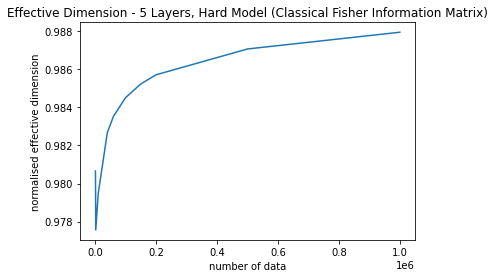

In [16]:
plt.plot(n, effdim)
plt.ylabel("normalised effective dimension")
#plt.ylim(ymax=1)
plt.xlabel("number of data")
plt.title("Effective Dimension - 5 Layers, Hard Model (Classical Fisher Information Matrix)")

In [17]:
np.save("2qubits_5layerhard_f_hats_pauli.npy", f)
np.save("2qubits_5layerhard_effective_dimension_pauli.npy", effdim)

In [18]:
eff_dimeasy = np.load("2qubits_5layer_effective_dimension_pauli.npy", allow_pickle=True)

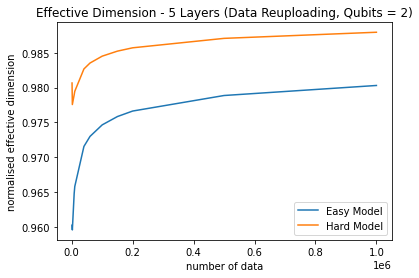

In [19]:
plt.plot(n, eff_dimeasy)
plt.plot(n, effdim)

plt.xlabel("number of data")
plt.ylabel("normalised effective dimension")
plt.title("Effective Dimension - 5 Layers (Data Reuploading, Qubits = 2)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)